# Продвинутый Python, семинар 12

**Лектор:** Петров Тимур

**Семинаристы:** Петров Тимур, Бузаев Федор, Дешеулин Олег, Коган Александра

**Spoiler Alert:** в рамках курса нельзя изучить ни одну из тем от и до досконально (к сожалению, на это требуется больше времени, чем даже 3 часа в неделю). Но мы попробуем рассказать столько, сколько возможно :)

## Один Поток (Singlethread) / Многопоточность (Multithread) / Мультипроцессинг (Multiprocess)

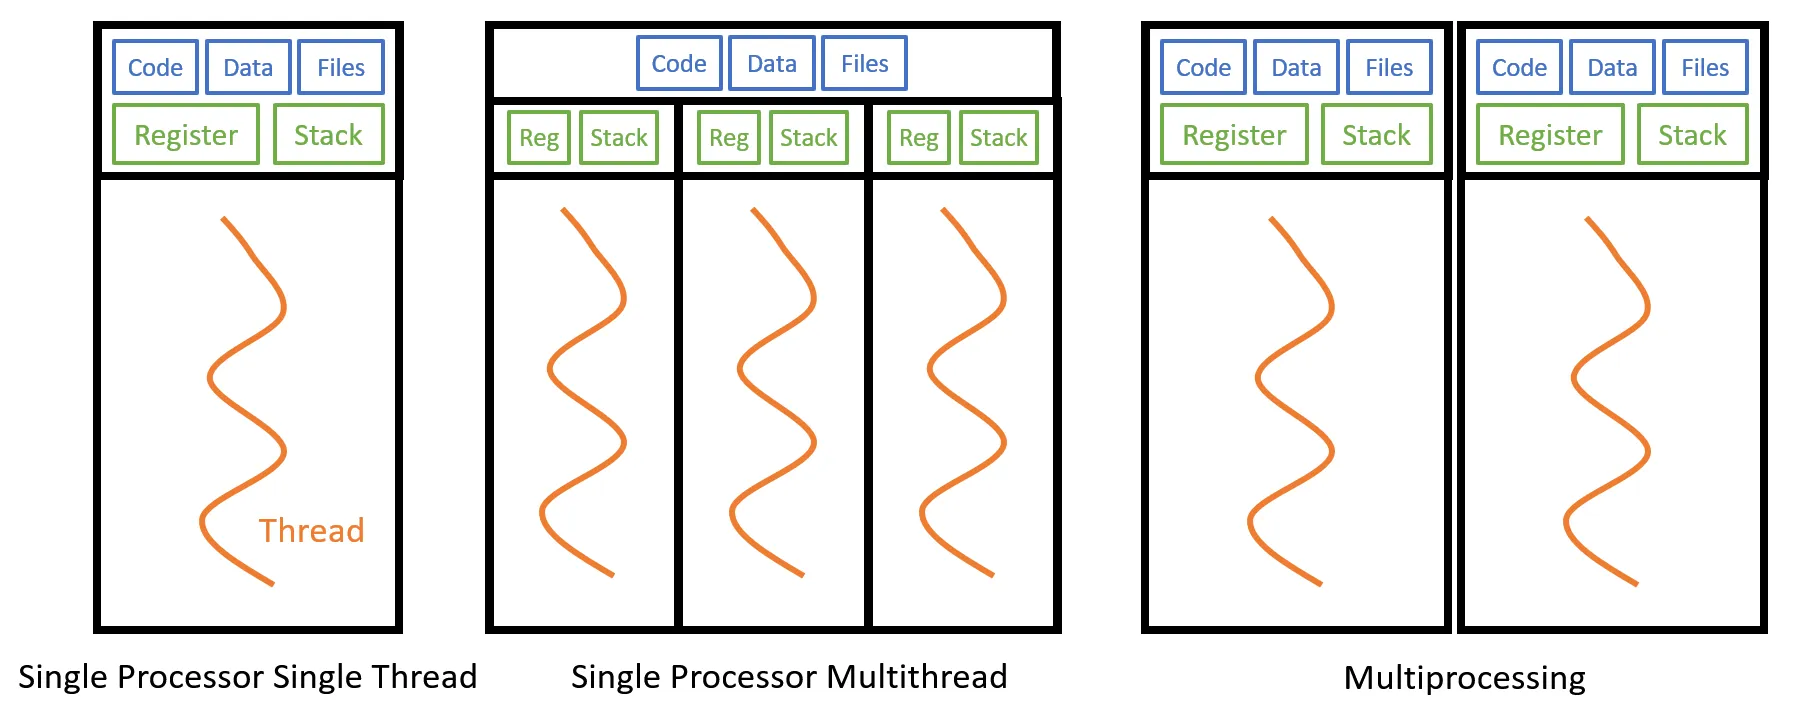
[click for source](https://towardsdatascience.com/multithreading-and-multiprocessing-in-10-minutes-20d9b3c6a867#:~:text=By%20formal%20definition%2C%20multithreading%20refers,run%20one%20or%20more%20threads)


Обычно программа работает в одном процессе и в одном одном потоке (thread). Однако внутри каждого процесса можно запустить нескольно потоков и они будут иметь свои виртуальные регистры и стек на машине. Это позволяет нам иметь у каждого потока свои значения переменных, но при этом все они запускают одинаковый код, и видят одинаковые данные.

Внутри же каждого потока можно независимо работать с данными или файлами, при этом они будут физически скопированы, что делает создание потока дорогой операцией. Можно представлять себе, что создание потока это запуск полностью независимой от основного программы. Иными словами, создается и запускается независимый интерпретатор python.

## GIL

Напомню, что мы выучили на лекции, что в python существует GIL (Global interpreter lock) и он капитально портит нам жизнь если мы запускаем нескольно потоков внутри python процесса:

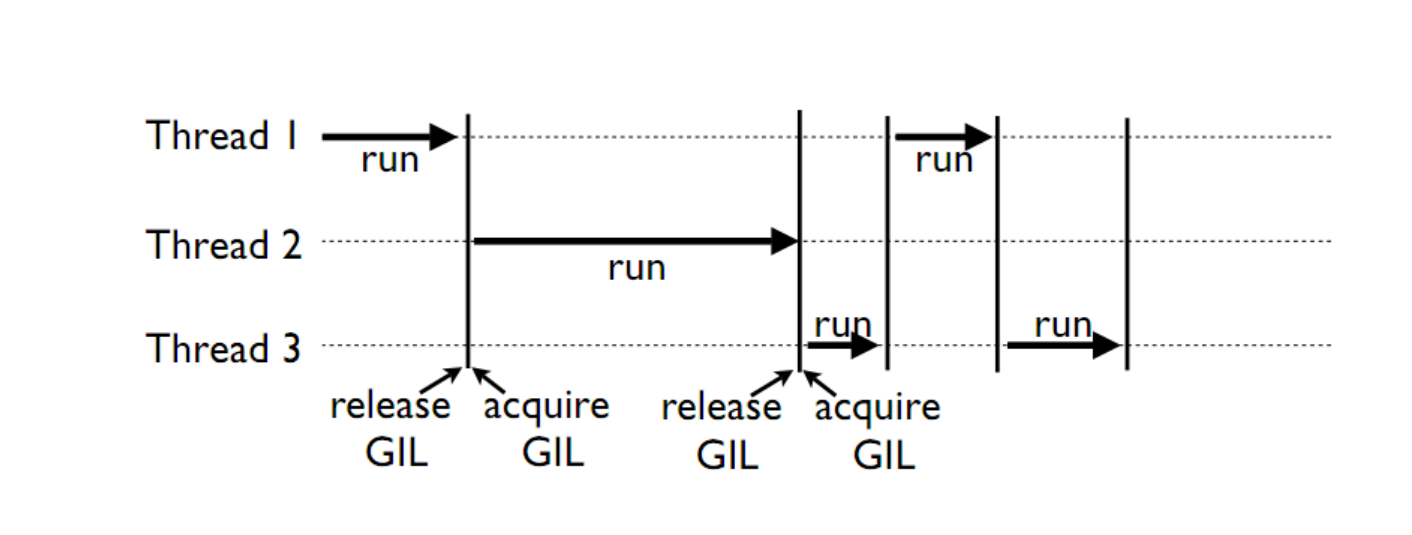

> "In CPython, the global interpreter lock, or GIL, is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once. This lock is necessary mainly because CPython's memory management is not thread-safe."



Видно что потоки часто ждут (idle) выполнения других, более того видно что вообще никогда потоки не выполняются одновременно, собственно потому что потоки используют один интерпретатор внутри.

**Зачем тогда нужны потоки вообще?**

### Пример использования потоков (thread)

In [ ]:
import threading
import sys


def thread_job(number):
    print('Hello {}'.format(number), flush=True) # Выводим в stdout, flush=True делает его non-blocking


def run_threads(count):
    threads = [
        threading.Thread(target=thread_job, args=(i,)) # создаем по потоку, назначаем, что он должен делать, можем отдельно передавать аргументы
        for i in range(0, count)
    ]
    for thread in threads:
        thread.start()  # каждый поток должен быть запущен
    for thread in threads:
        thread.join()  # дожидаемся исполнения всех потоков (можем не дожидаться, дождаться надо, потому что может закончиться родительский тред)


run_threads(25)
print("finish") #А тут уже что-то перемешалось (потому что поток вывода один)

Hello 0
Hello 1
Hello 2
Hello 3
Hello 4
Hello 5
Hello 6
Hello 7
Hello 8
Hello 9
Hello 10
Hello 11
Hello 12
Hello 13Hello 14

Hello 15
Hello 16
Hello 17
Hello 18
Hello 19
Hello 20
Hello 21
Hello 22
Hello 23
Hello 24
finish


Месиво какое-то.. А что если попытаться считать?

In [ ]:
import threading
import random
import time
import sys


def thread_job():
    global counter
    old_counter = counter
    time.sleep(random.randint(0, 1)) #засыпаем, чтобы вызвать проблему
    counter = old_counter + 1
    print('{} '.format(counter), end='')
    sys.stdout.flush()


counter = 0
threads = [threading.Thread(target=thread_job) for _ in range(4)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
print(counter)

1 1 1 1 1


Не работает! Для того чтобы починить принято использовать locks, например mutex (самый простой лок)

В целом такая ситуация называется race condition.

Lock блокирует использование ресурсов на время выполнения контекста (собственно того что залочено)

In [ ]:
import threading
import random
import time
import sys


def thread_job():
    with lock: # Входим и блокируем ресурсы
        global counter
        old_counter = counter
        time.sleep(random.randint(0, 1))
        counter = old_counter + 1
        print('{} '.format(counter), end='')
        sys.stdout.flush()


lock = threading.Lock()
counter = 0
threads = [threading.Thread(target=thread_job) for _ in range(4)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
print(counter)

1 2 3 4 4


Есть некоторые проблемы с использованием lock налево и направо:
* вычисления могут перестать быть асинхронными
* deadlock

Кроме lock, в типичную парадигму асинхронных вычислений входит semaphore (светофор), lock c счетчиком, вот так это делается в питоне.



In [ ]:
import threading

# Создадим semaphore с счетчиком до 3х
semaphore = threading.Semaphore(3)

def access_shared_resource(thread_id):
    print(f"Thread {thread_id} пытается начать работу!")

    semaphore.acquire()

    print(f"Thread {thread_id} заблокировал semaphore.")

    # Поспим :)
    time.sleep(1)

    # Отпустим semaphore
    semaphore.release()
    print(f"Thread {thread_id} отпустил semaphore.")

threads = []
for i in range(5):
    thread = threading.Thread(target=access_shared_resource, args=(i,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

Thread 0 пытается начать работу!
Thread 0 заблокировал semaphore.
Thread 1 пытается начать работу!
Thread 1 заблокировал semaphore.
Thread 2 пытается начать работу!
Thread 2 заблокировал semaphore.
Thread 3 пытается начать работу!
Thread 4 пытается начать работу!
Thread 0 отпустил semaphore.Thread 3 заблокировал semaphore.

Thread 1 отпустил semaphore.
Thread 4 заблокировал semaphore.
Thread 2 отпустил semaphore.
Thread 3 отпустил semaphore.
Thread 4 отпустил semaphore.


Задачка на использование будет в домашке :)

Смысл светофора чтоб не разрешать слишком большому числу ресурсов пользоваться cpu (скажем например отправлять что-то через network)


Ура, изучили lock, дальше увидим пример уже в задачках :)

### Философы и deadlock

За круглым столом обедают 4 философa (thread), берут вилку в обе руки за обедом, вилок тоже 4. Как философ поел он пытается поесть снова, поскольку как истинный философ он ненасытен. Однако, если философ не может поесть он проклинает погромиста. Попробуйте избежать проклятия :)

In [ ]:
import threading

num_philosophers = 4
forks = [threading.Lock() for _ in range(num_philosophers)]
update_lock = threading.Lock()
statuses = [0] * num_philosophers

def check_status():
    with update_lock:
      return sum(statuses) != num_philosophers

def philosopher(i):
    while check_status():
        # Взяли палочки-вилочки
        forks[i].acquire()
        forks[(i + 1) % num_philosophers].acquire()

        # Покушали
        time.sleep(((i % 2) + 0.1) * 0.5)
        with update_lock:
            statuses[i] = 1
            print(f'Philosopher {i} finished: {statuses}')

        # Вернули
        forks[i].release()
        forks[(i + 1) % num_philosophers].release()


philosophers = [threading.Thread(target=philosopher, args=(i,)) for i in range(num_philosophers)]
for p in philosophers:
    p.start()
for p in philosophers:
    p.join()

Philosopher 0 finished: [1, 0, 0, 0]
Philosopher 2 finished: [1, 0, 1, 0]
Philosopher 0 finished: [1, 0, 1, 0]
Philosopher 2 finished: [1, 0, 1, 0]
Philosopher 0 finished: [1, 0, 1, 0]
Philosopher 2 finished: [1, 0, 1, 0]
Philosopher 0 finished: [1, 0, 1, 0]
Philosopher 2 finished: [1, 0, 1, 0]
Philosopher 0 finished: [1, 0, 1, 0]
Philosopher 2 finished: [1, 0, 1, 0]
Philosopher 0 finished: [1, 0, 1, 0]
Philosopher 2 finished: [1, 0, 1, 0]
Philosopher 3 finished: [1, 0, 1, 1]
Philosopher 0 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
Philosopher 0 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
Philosopher 0 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
Philosopher 0 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
Philosopher 0 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
Philosopher 0 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
Philosopher 0 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
P

Exception in thread Thread-356 (philosopher):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-169-49dd523b09fc>", line 25, in philosopher
RuntimeError: release unlocked lock


Philosopher 3 finished: [1, 1, 1, 1]


Ладно, запустим с 5ью!

In [ ]:
import threading

num_philosophers = 5
forks = [threading.Lock() for _ in range(num_philosophers)]
update_lock = threading.Lock()
statuses = [0] * num_philosophers


philosophers = [threading.Thread(target=philosopher, args=(i,)) for i in range(num_philosophers)]
for p in philosophers:
    p.start()
for p in philosophers:
    p.join()

Philosopher 0 finished: [1, 0, 0, 0, 0]
Philosopher 2 finished: [1, 0, 1, 0, 0]
Philosopher 0 finished: [1, 0, 1, 0, 0]
Philosopher 0 finished: [1, 0, 1, 0, 0]
Philosopher 0 finished: [1, 0, 1, 0, 0]
Philosopher 0 finished: [1, 0, 1, 0, 0]
Philosopher 0 finished: [1, 0, 1, 0, 0]
Philosopher 0 finished: [1, 0, 1, 0, 0]
Philosopher 4 finished: [1, 0, 1, 0, 1]
Philosopher 3 finished: [1, 0, 1, 1, 1]
Philosopher 3 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]


KeyboardInterrupt: ignored

DEADLOCK!

А как чинить... решите в домашке :)

### Пример использования процессов (multiprocessing)

воспользовался: https://kemingy.github.io/blogs/python-multiprocessing/

In [ ]:
!ps # посмотреть на все процессы в системе

    PID TTY          TIME CMD
      1 ?        00:00:00 docker-init
      7 ?        00:00:03 node
     18 ?        00:00:00 oom_monitor.sh
     20 ?        00:00:00 run.sh
     23 ?        00:00:00 kernel_manager_
     36 ?        00:00:00 tail
     60 ?        00:00:07 python3 <defunct>
     61 ?        00:00:00 colab-fileshim.
     82 ?        00:00:05 jupyter-noteboo
     83 ?        00:00:00 dap_multiplexer
    475 ?        00:01:44 python3
    506 ?        00:00:01 python3
    535 ?        00:00:00 language_servic
    543 ?        00:01:42 node
   2761 ?        00:00:00 sleep
   2762 ?        00:00:00 ps


Как на лекции (и как chatgpt ответит):

In [ ]:
from multiprocessing import Pool

def my_function(x):
    return x*x

with Pool() as p:
    result = p.map(my_function, range(10))

#### Fork or Spawn
На лекции уже был простой пример с multiprocessing. Однако внутри multiprocessing есть подводный камень (спойлер: не один). Есть два встроенных алгоритма создания процесса:

* spawn: The parent process starts a fresh python interpreter process. The child process will only inherit those resources necessary to run the process objects run() method. In particular, unnecessary file descriptors and handles from the parent process will not be inherited.

* fork: Процесс-родитель использует os.fork() чтобы форкнуть Python interpreter. Как только процесс стартует он абсолютно такой же как родитель. Все ресурсы унаследованы. В чем проблема? Проблема в том что нужно lockать (как в философах), можно получить state corruption, если в момент forka вы меняли что-то в своем процессе... А еще ручная очистка памяти.. Тем не менее оптимальный способ довольно часто.

* forkserver: Заранее сделанный fork n раз. В некотором смысле похоже на работу std::vector с памятью: заранее выделяем себе n процессов, они висят в idle до востребования.

##### Зависимость от операционных систем:
Default (что означает что в зависимости от OS программа ведет себя сильно по разному!) :
* Windows (win32): spawn
* macOS (darwin): spawn
* Linux (unix): fork

Более того win еще и не все поддерживает:
* Windows (win32): spawn
* macOS (darwin): spawn, fork, forkserver.
* Linux (unix): spawn, fork, forkserver.

In [ ]:
import multiprocessing as mp

In [ ]:
mp.get_all_start_methods()

['fork', 'spawn', 'forkserver']

In [ ]:
%%writefile mp.py

import multiprocessing as mp
import os


class Dummy:
    def __init__(self) -> None:
        print(f"init in pid: {os.getpid()}")


Dummy()
x = None


def task():
    if x is None:
        print("x is None")


if __name__ == "__main__":
    p = mp.get_context("spawn").Process(target=task)
    p.start()
    p.join()

Overwriting mp.py


In [ ]:
!python mp.py

init in pid: 22166
init in pid: 22169
x is None


In [ ]:
%%writefile mp.py

import multiprocessing as mp
import os


class Dummy:
    def __init__(self) -> None:
        print(f"init in pid: {os.getpid()}")


Dummy()
x = None


def task():
    if x is None:
        print("x is None")


if __name__ == "__main__":
    p = mp.get_context("fork").Process(target=task)
    p.start()
    p.join()

Writing mp.py


In [ ]:
!python mp.py

init in pid: 22083
x is None


Кто объяснит разницу?

In [ ]:
%%writefile mp.py

import time
import psutil
import multiprocessing as mp


def display_memory_usage(msg=""):
    process = psutil.Process()
    print(msg, ">", process.memory_info())


def processing():
    display_memory_usage("child ")

data = list(range(10000000))

if __name__ == "__main__":
    p = mp.get_context("fork").Process(target=processing)
    p.start()

    time.sleep(0.1)
    display_memory_usage("parent")
    p.join()

Overwriting mp.py


In [ ]:
!python mp.py

child  > pmem(rss=410710016, vms=427364352, shared=2957312, text=2822144, lib=0, data=414511104, dirty=0)
parent > pmem(rss=414429184, vms=427364352, shared=6668288, text=2822144, lib=0, data=414511104, dirty=0)


In [ ]:
%%writefile mp.py

import time
import psutil
import multiprocessing as mp


def display_memory_usage(msg=""):
    process = psutil.Process()
    print(msg, ">", process.memory_info())


def processing():
    display_memory_usage("child ")

data = list(range(10000000))

if __name__ == "__main__":
  p = mp.get_context("spawn").Process(target=processing)
  time.sleep(0.1)
  p.start()

  time.sleep(0.1)
  display_memory_usage("parent")
  p.join()

Overwriting mp.py


In [ ]:
!python mp.py

parent > pmem(rss=414724096, vms=427421696, shared=6885376, text=2822144, lib=0, data=414527488, dirty=0)
child  > pmem(rss=415166464, vms=427573248, shared=7127040, text=2822144, lib=0, data=414679040, dirty=0)


Эти два примера тут чтобы показать со всех сторон 2 возможных стула которые у нас есть при работе с python.multiprocessing. Нужно скопировать все необходимые данные для работы вашей функции.
 * Fork: позволяет оптимизировать этот процесс, но если child/parent что-то поменяет в процессе fork... Могут утечь ресурсы, все очень страшно и опасно, нужно работать с ним очень осторожно. Кроме того, передаются например все lockи и легко можно задедлочить и child и parent.
 * Spawn: Новый чистые python, однако в нем нужно сделать все импорты (в том числе случайные иниты, как в примере выше) и скопировтаь все остальное. По дефолту - лучший выбор, но долгий и немного капризный (код нужно чистить).

Cмешная статья как в питоне сломали garbage collector и при чем тут concurency: https://codewithoutrules.com/2017/08/16/concurrency-python/

### Subprocess и pipe

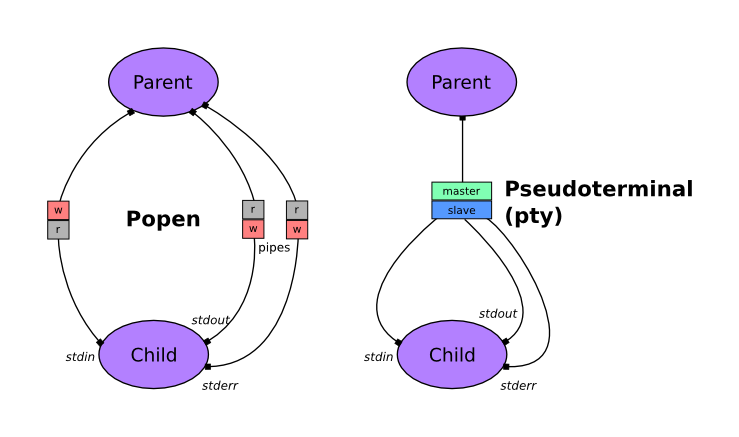

А что если хочется запустить какой-то процесс.. и это не python. Или python, но приложение вполне себе независимое и не хочется лезть как-то в код, хочется запустить main.py и вперед.

Для таких случаев в unix придуманы ~процессы сабмиссивы~ подпроцессы. Общаться можно с ними через pipe, то как именно направить pipe решает программист :)

Пример создания подпроцессов с помощью библиотеки subprocess:

In [ ]:
import subprocess
import io

In [ ]:
result = subprocess.run("ls -l", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
result

CompletedProcess(args='ls -l', returncode=0, stdout='total 4\ndrwxr-xr-x 1 root root 4096 Oct 26 13:24 sample_data\n', stderr='')

In [ ]:
result = subprocess.run("sl -l", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
result

CompletedProcess(args='sl -l', returncode=127, stdout='', stderr='/bin/sh: 1: sl: not found\n')

Своя программа.
Заметим что мы перенаправии с помощью pipe и вход и вывод и print...

In [ ]:
%%writefile calculator.py
import sys

if __name__ == "__main__":
    while True:
        x = sys.stdin.readline().lower().strip()
        sys.stdout.write(str(x) + '\n')
        print(x, 'to print')
        if x == '':
            continue
        if x == 'stop':
            break
        result = eval(x)
        print(result, 'to print')
        sys.stdout.write(str(result) + '\n')

Overwriting calculator.py


In [ ]:
proc = subprocess.Popen(["python", "calculator.py"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [ ]:
proc

<Popen: returncode: None args: ['python', 'calculator.py']>

In [ ]:
stdout, stderr = proc.communicate(input='5 + 5\nstop'.encode())

In [ ]:
print(stdout.decode())

5 + 5
5 + 5 to print
10 to print
10
stop
stop to print



In [ ]:
print(stderr.decode())

In [ ]:
proc.kill()

## Сравнения и графики

In [ ]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string

In [ ]:
def visualize_runtimes(ax, results, title):
    start,stop = np.array(results).T
    ax.barh(np.arange(len(start)),stop - start, left = start)
    ax.grid(axis='x')
    ax.set_ylabel("Tasks")
    ax.set_xlabel("Seconds")
    ax.set_title(title)
    return stop[-1]-start[0]

In [ ]:
def multithreading(func, inputs, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, [(input_one, begin_time) for input_one in inputs])
    return list(res)

def multiprocessing(func, inputs, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, [(input_one, begin_time) for input_one in inputs])
    return list(res)

In [ ]:
def visualize_fn(fn, inputs, jobs = [1, 2, 4, 16]):
    fig = plt.figure(figsize=(15, 25))
    axs = fig.subplot_mosaic([[f'{num_jobs}_{executor}' for executor in ['thread', 'process']] for num_jobs in jobs])
    for ax_name in axs:
        num_jobs, executor_name = ax_name.split('_')
        num_jobs = int(num_jobs)
        if executor_name == 'thread':
            executor = multithreading
        else:
            executor = multiprocessing
        cur_inputs = [inputs[i * len(inputs) // num_jobs : (i + 1) * len(inputs) // num_jobs] for i in range(num_jobs)]
        visualize_runtimes(axs[ax_name], executor(fn, cur_inputs, num_jobs),f"{num_jobs} {executor_name}")
    plt.show()

### IO Heavy

#### Скачаем собственно семинар

In [ ]:
from urllib.request import urlopen

def download(x):
    input_urls, start_time = x
    start = time.time() - start_time
    for input_url in input_urls:
        resp = urlopen(input_url)
    stop = time.time() - start_time
    return start,stop

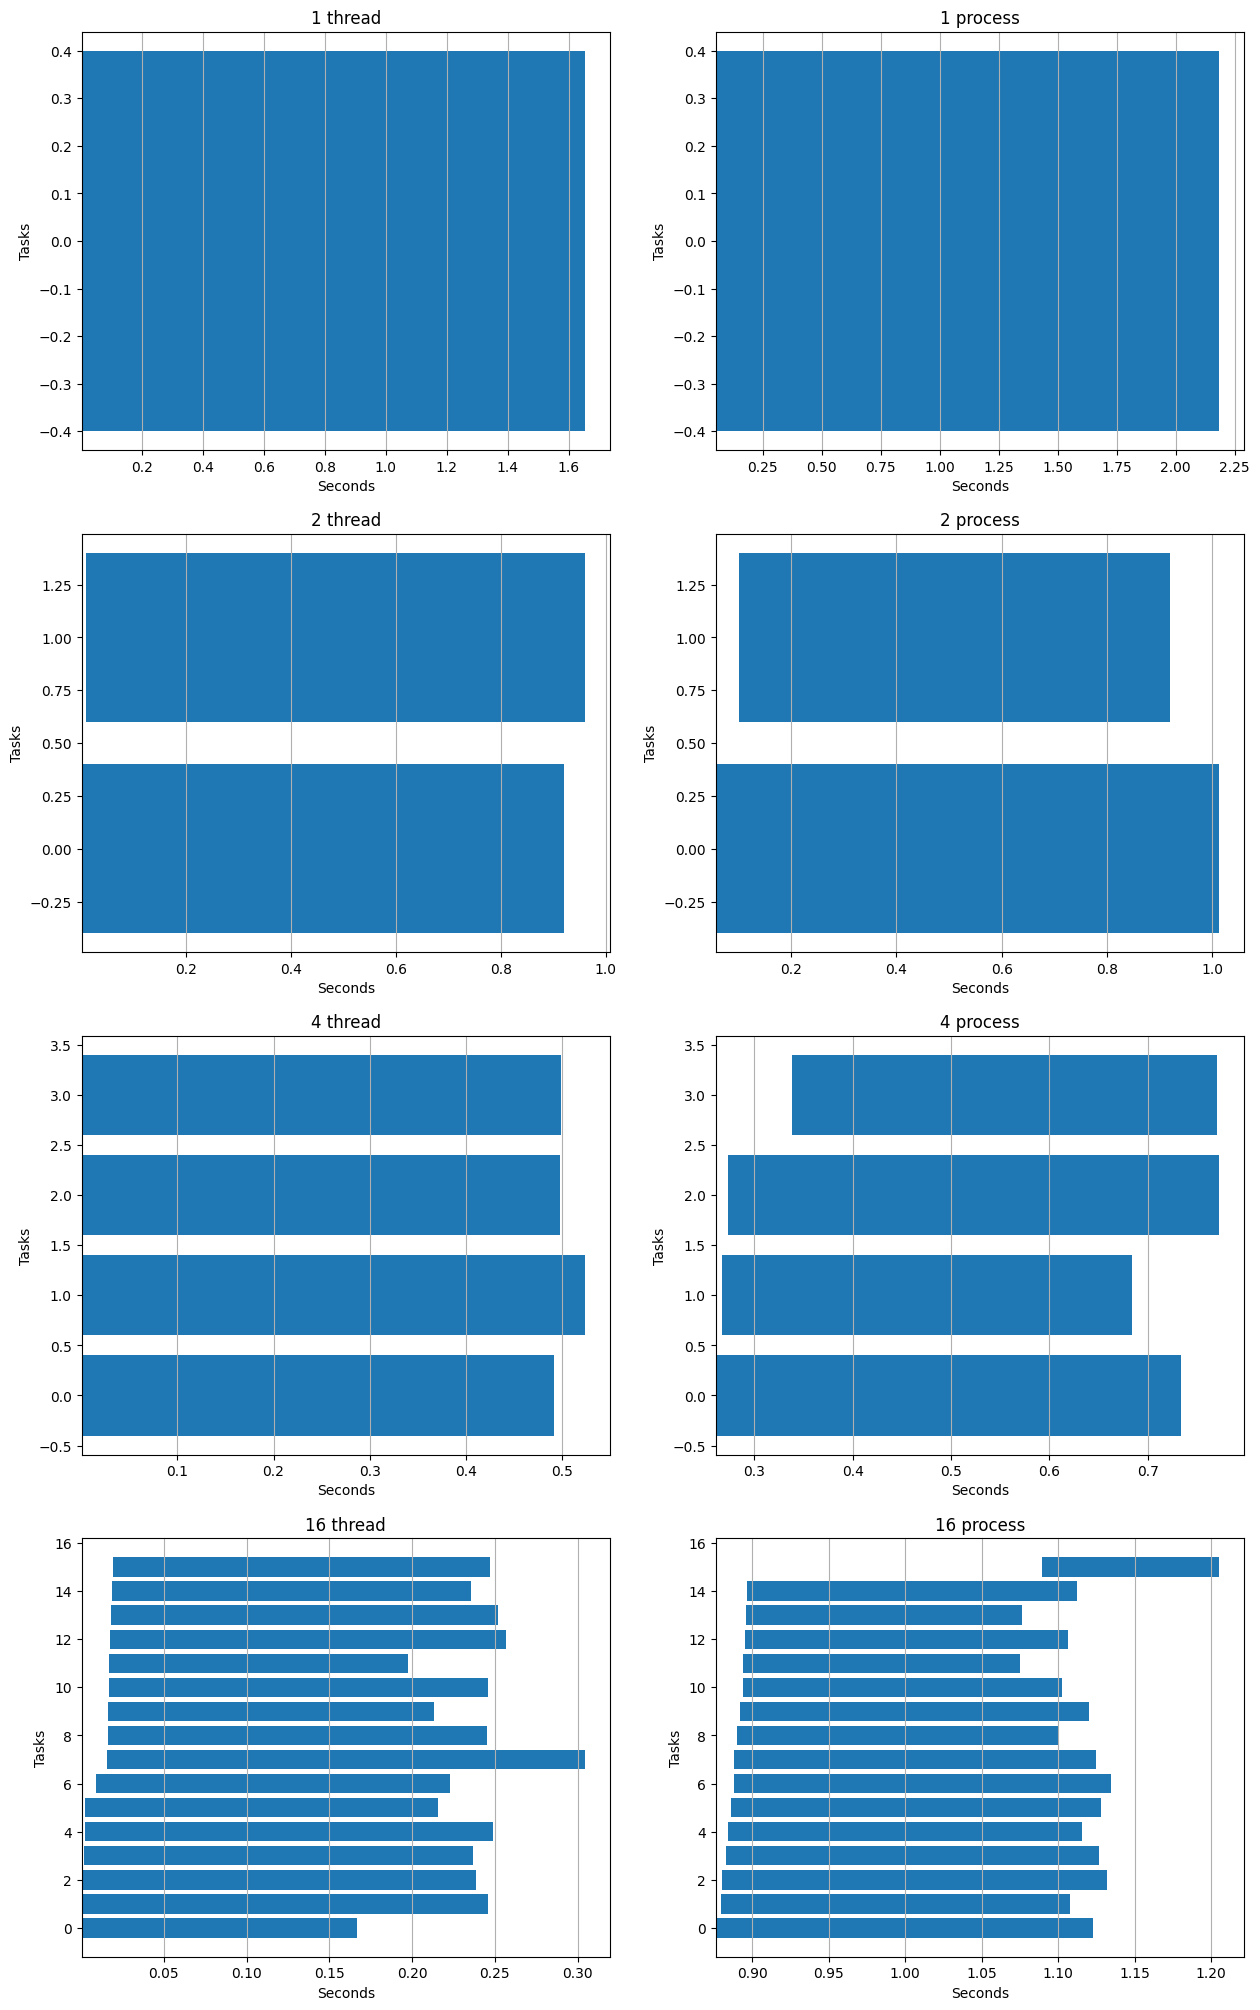

In [ ]:
visualize_fn(download, ['https://raw.githubusercontent.com/Palladain/Deep_Python_2023/main/week06/Seminar_6_solved.ipynb'] * 32)

#### Напишем файл

In [ ]:
# это занимает время
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**6))

def io_heavy(x):
    writable_text, start_time = x
    start = time.time() - start_time
    f = open(f'output.txt', 'wt', encoding='utf-8')
    f.write(str(writable_text))
    f.close()
    stop = time.time() - start_time
    return start,stop

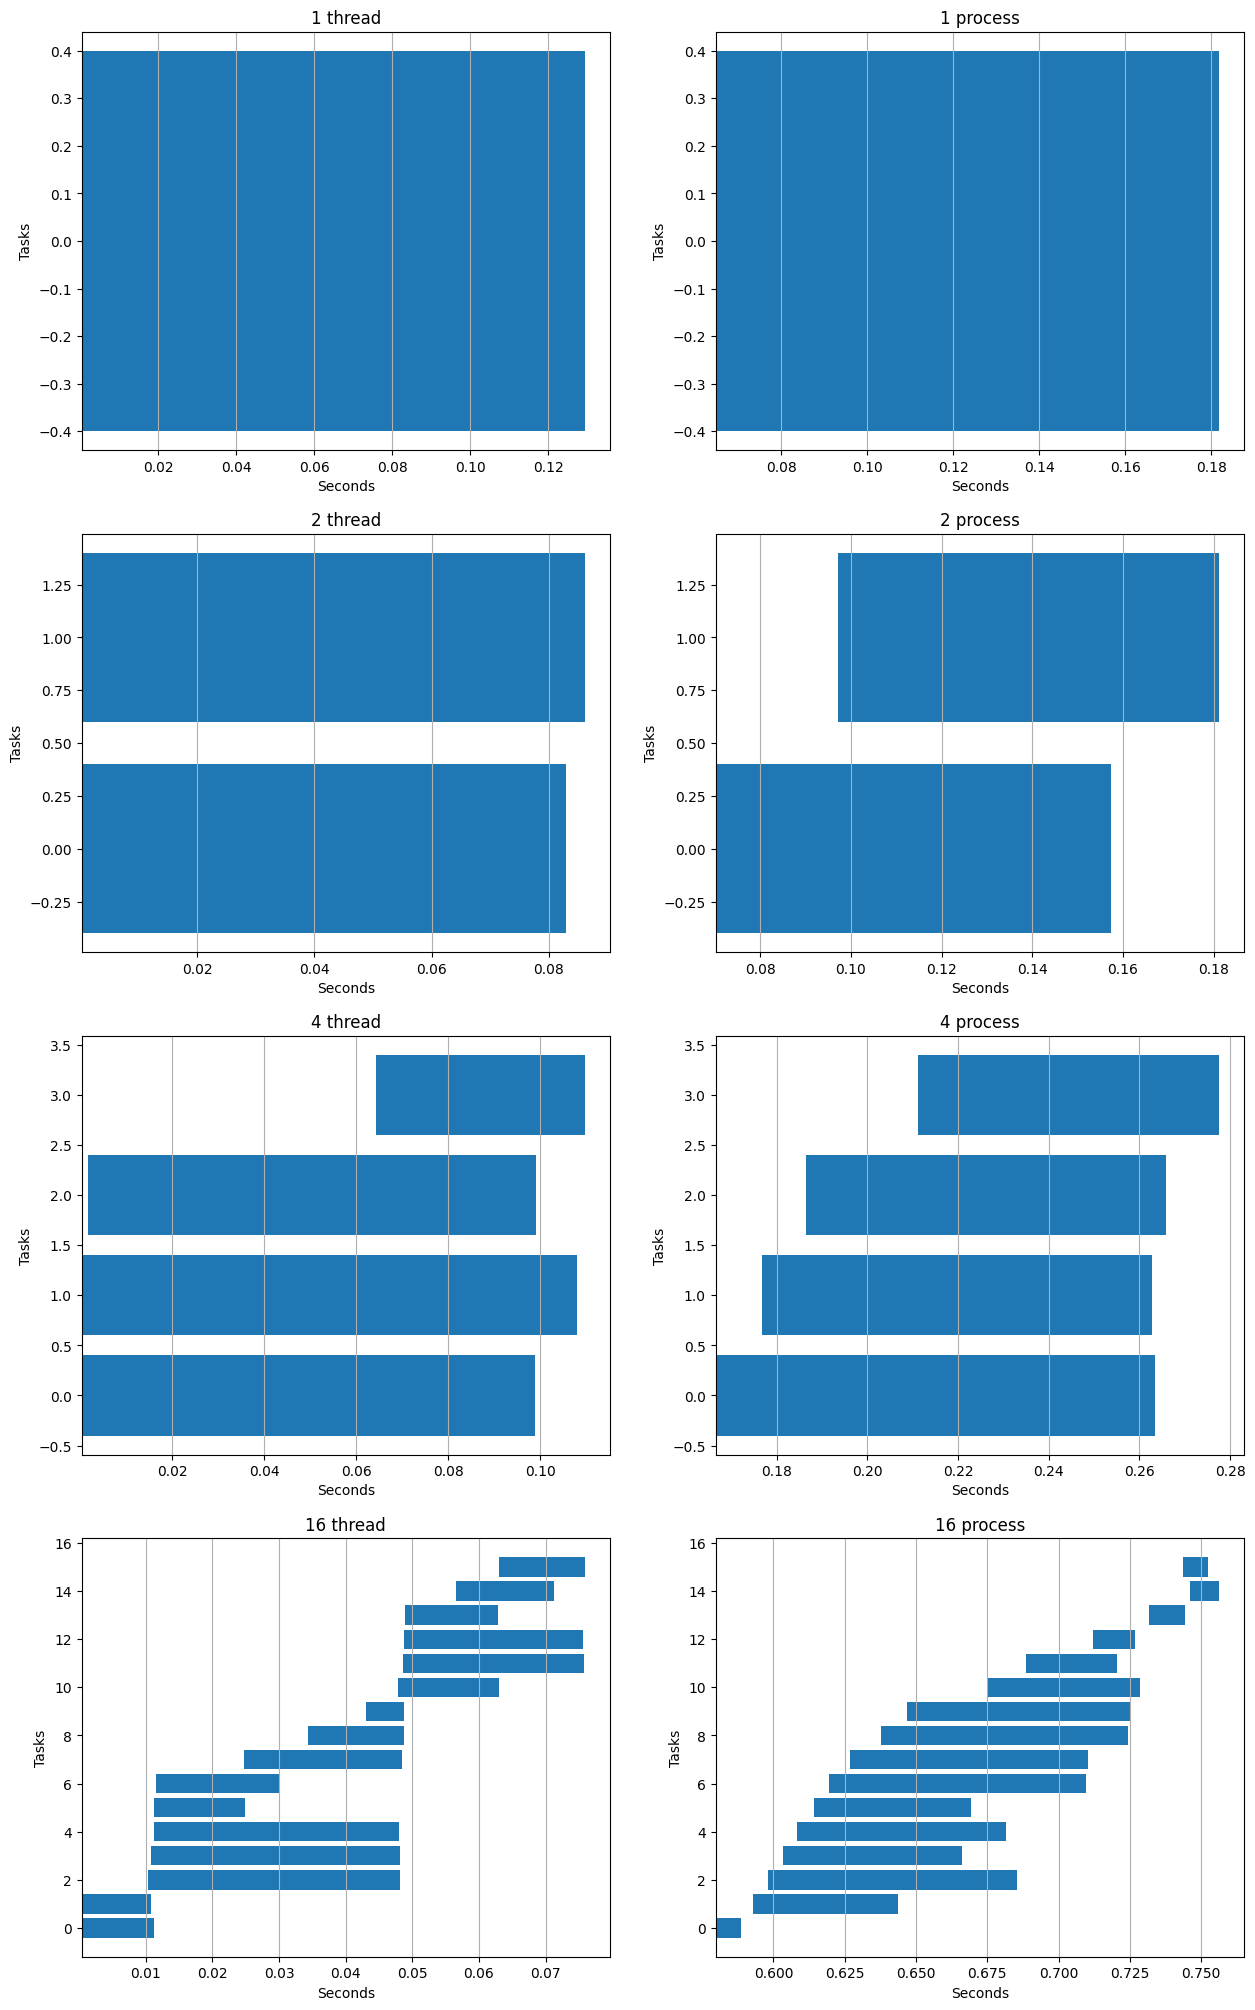

In [ ]:
visualize_fn(io_heavy, [TEXT] * 16)

Абстрактный Василий решил написать IO heavy функцию, но почему-то для нее threading не оказывается лучше.. почему?

In [ ]:
def io_heavy_broken(x):
    _, start_time = x
    start = time.time() - start_time
    text = ''.join(random.choice(string.ascii_lowercase) for i in range(10**5))
    f = open(f'{text[:10]}.txt', 'w', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - start_time
    return start,stop

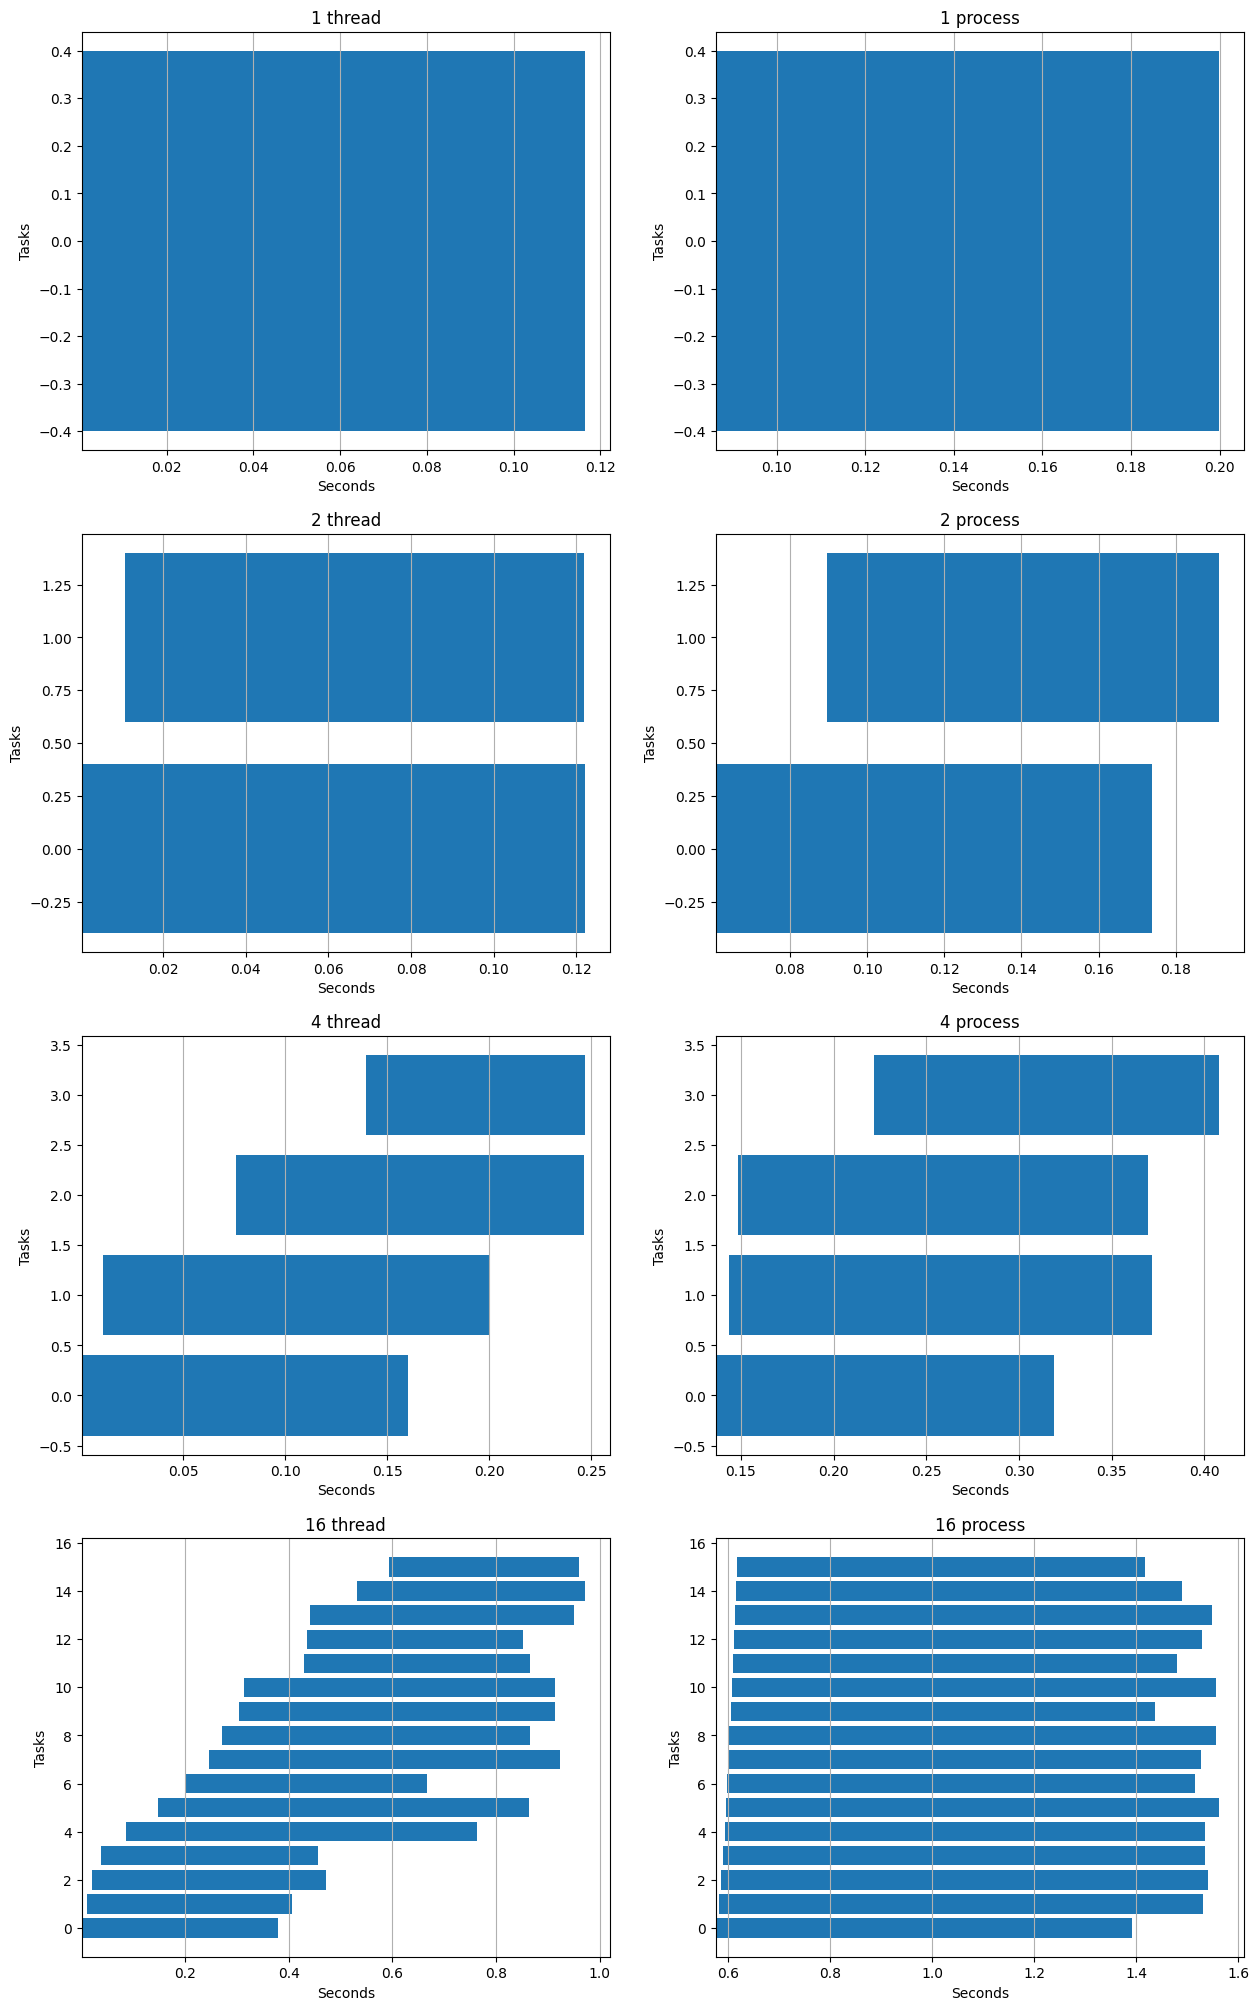

In [ ]:
visualize_fn(io_heavy_broken, [_] * 16)

Хинт: Важно следить за тем что именно IO-bounded операции распаралеливаются

### CPU-heavy вычисления на чистом питоне

In [ ]:
import math

def is_prime(x):
    nums, start_time = x
    start = time.time() - start_time
    for num in nums:
      for i in range(2, math.ceil(math.sqrt(num))):
          if num % i == 0:
              break
    stop = time.time() - start_time
    return start, stop

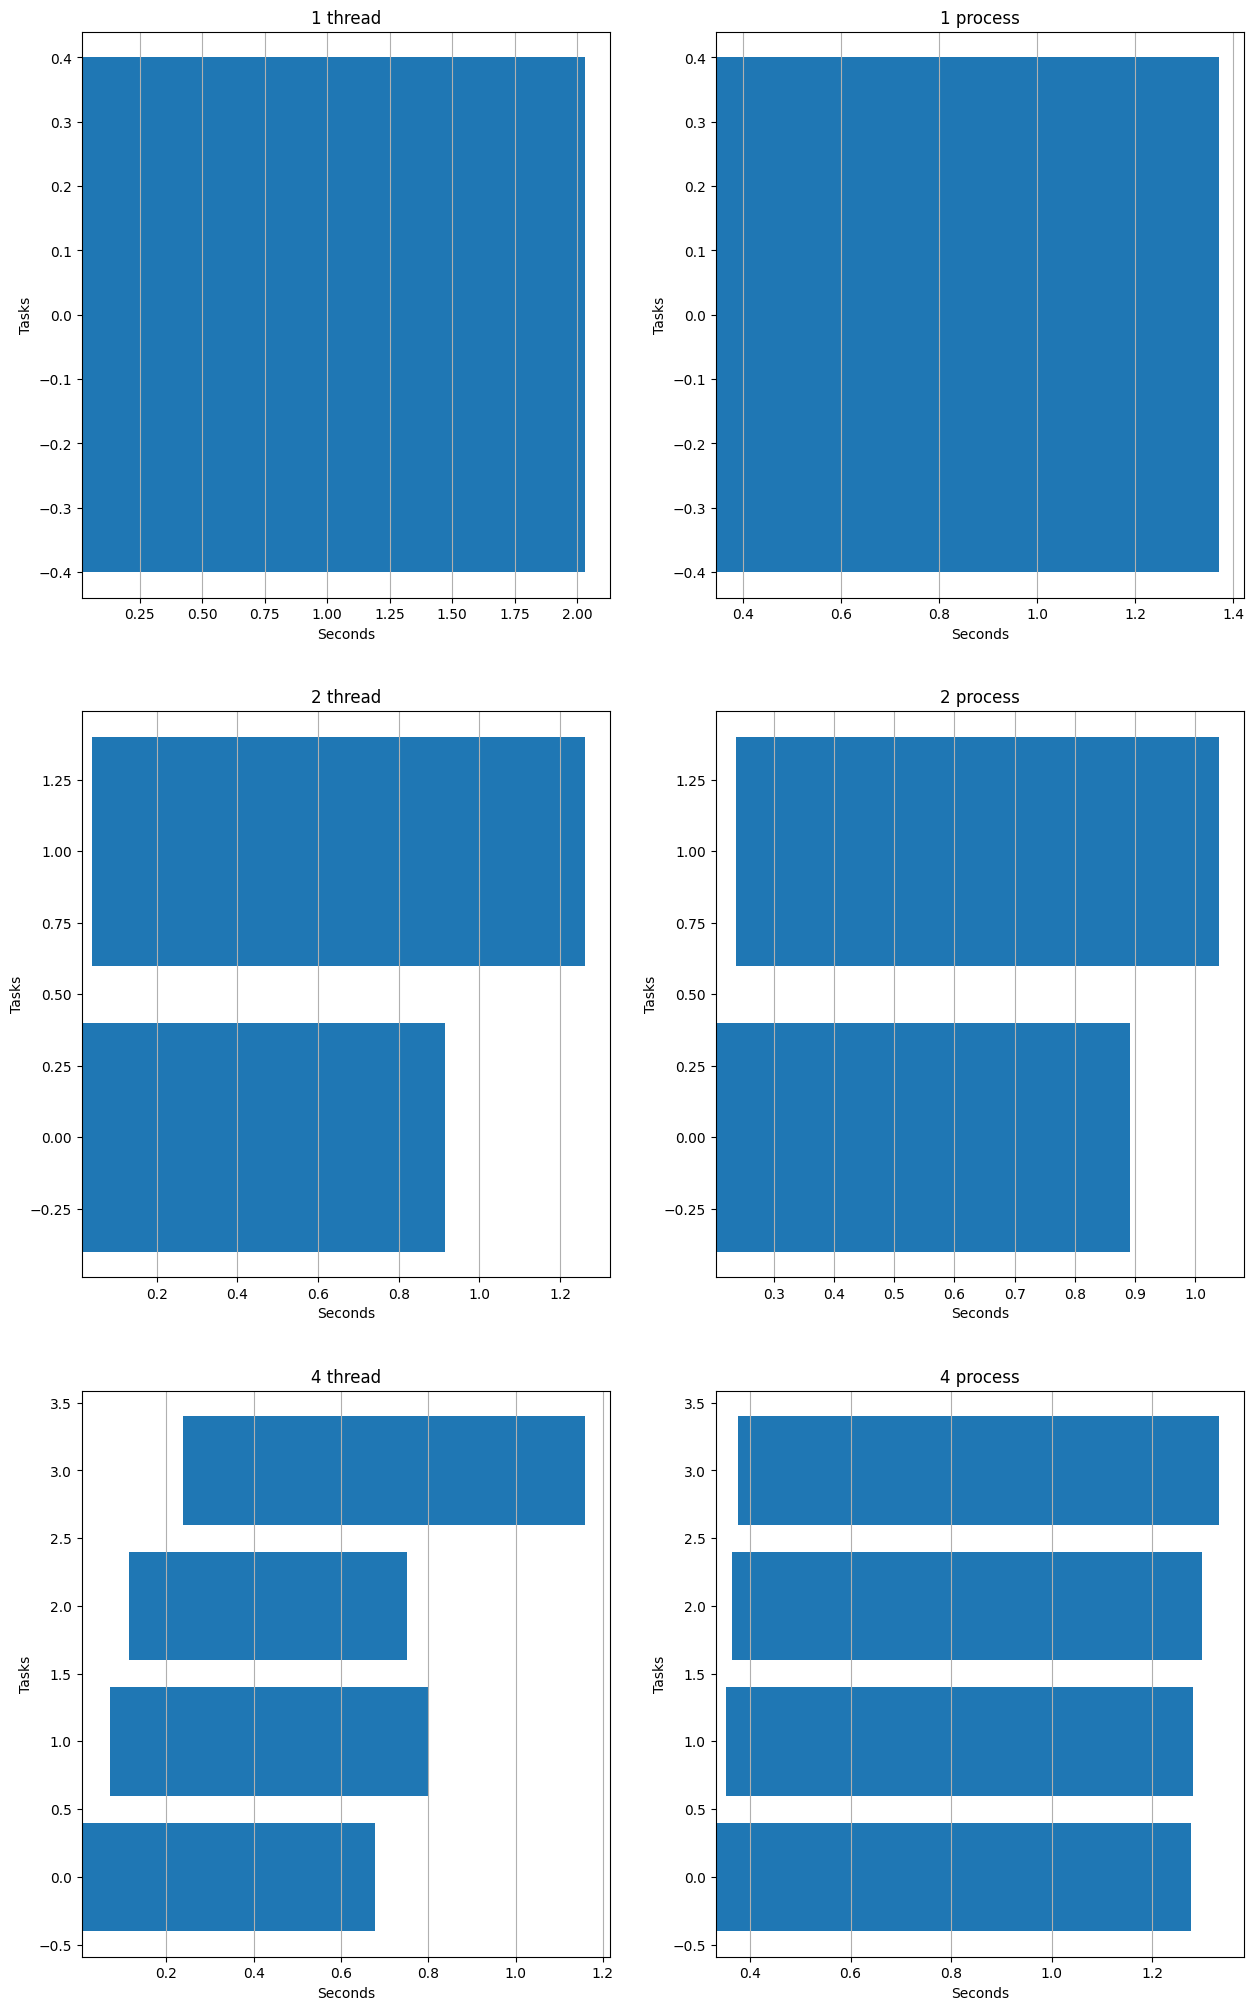

In [ ]:
visualize_fn(is_prime, list(range(400000, 500000)), [1, 2, 4])

Почему быстрее всего 2 процесса?

Это СPU-bounded вычисления, они подпадают под GIL и в колабе всего два CPU...

Еще видно что питон тут делает некий кэшинг, чем очень мешает нам увидеть желаемые графики, при этом cache shared между потоками, но не между процессами...

### Numpy и threading/multiprocessing

In [ ]:
def exp(x):
    idx, start_time = x
    start = time.time() - start_time
    np.exp(a[idx])
    stop = time.time() - start_time
    return start, stop

DIMS = 3000
SIZE = 16
a = np.random.rand(SIZE, DIMS,DIMS)

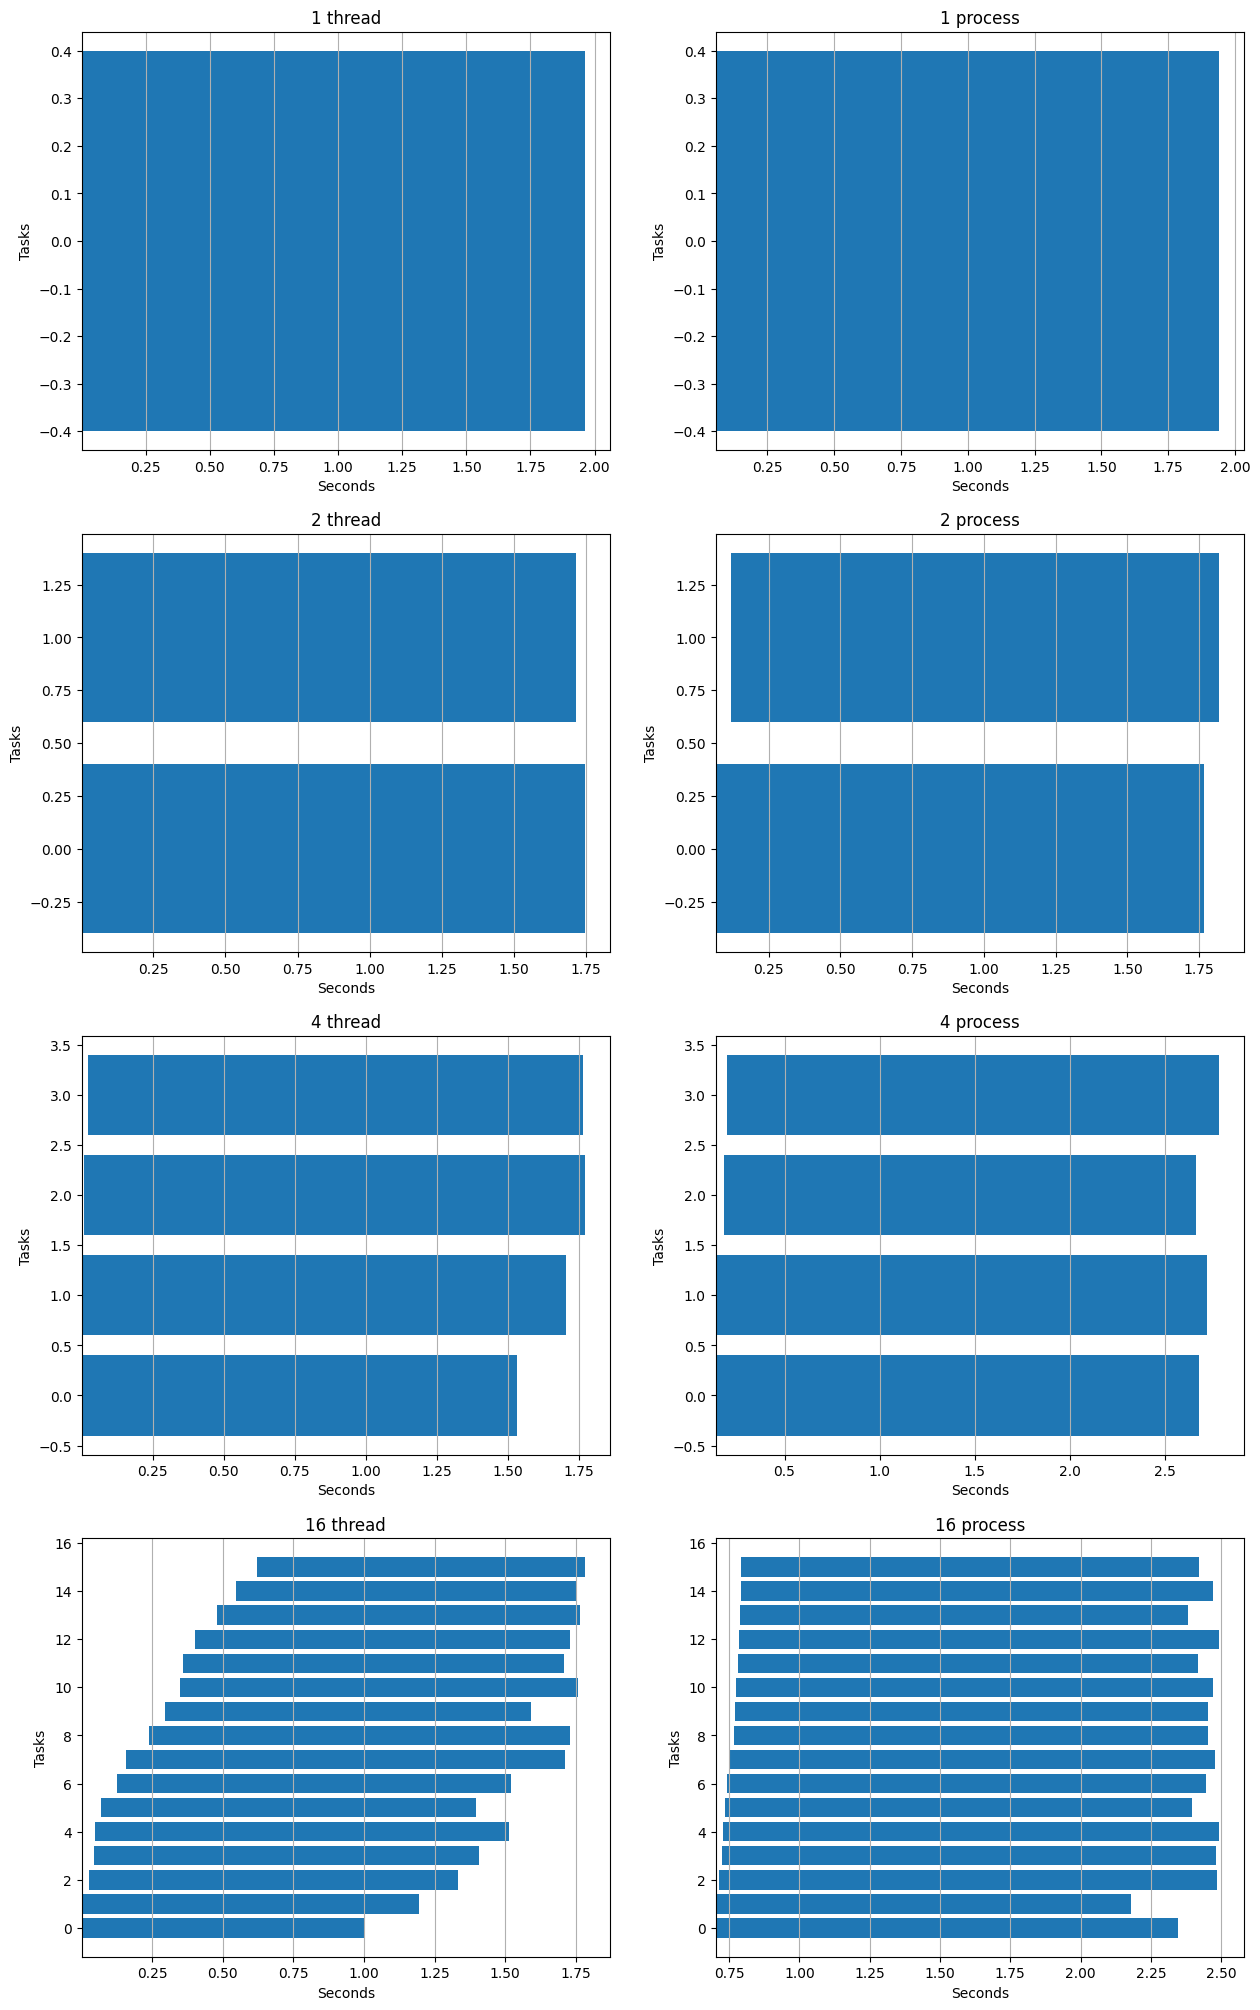

In [ ]:
visualize_fn(exp, [i for i in range(16)])

Почему не работает? Потому что некоторые (не все) вычисления в Numpy не блокируют GIL.

Но! обычно vectorized все равно быстрее:

In [ ]:
%timeit np.exp(a)

1.59 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### PIL: Более реальный пример, GIL уже играет роль

Давайте скажем что наша задача быстро читать картинки с диска, сжимать их и писать в другую папку на диске.

Как будем реализовывать?

In [ ]:
import torchvision

In [ ]:
torchvision.datasets.Flowers102(root='data/', split='train', download=True)

100%|██████████| 344862509/344862509 [00:12<00:00, 26550750.94it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1023100.39it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13373414.73it/s]


Dataset Flowers102
    Number of datapoints: 1020
    Root location: data/
    split=train

In [ ]:
import os

input_dir = 'data/flowers-102/jpg'
output_dir = 'data/flowers-102/compressed_jpg'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def compress_image(input_path, output_path, factor=0.3):
    img = Image.open(input_path)
    width, height = img.size
    new_width = int(width * factor)
    new_height = int(height * factor)
    img = img.resize((new_width, new_height), Image.LANCZOS)
    img.save(output_path)

def process_image(x):
    image_files, start_time = x
    start = time.time() - start_time
    for image_file in image_files:
      input_path = os.path.join(input_dir, image_file)
      output_path = os.path.join(output_dir, image_file)
      compress_image(input_path, output_path, factor=0.5)
    stop = time.time() - start_time
    return start, stop

In [ ]:
all_files = os.listdir(input_dir)[:600]

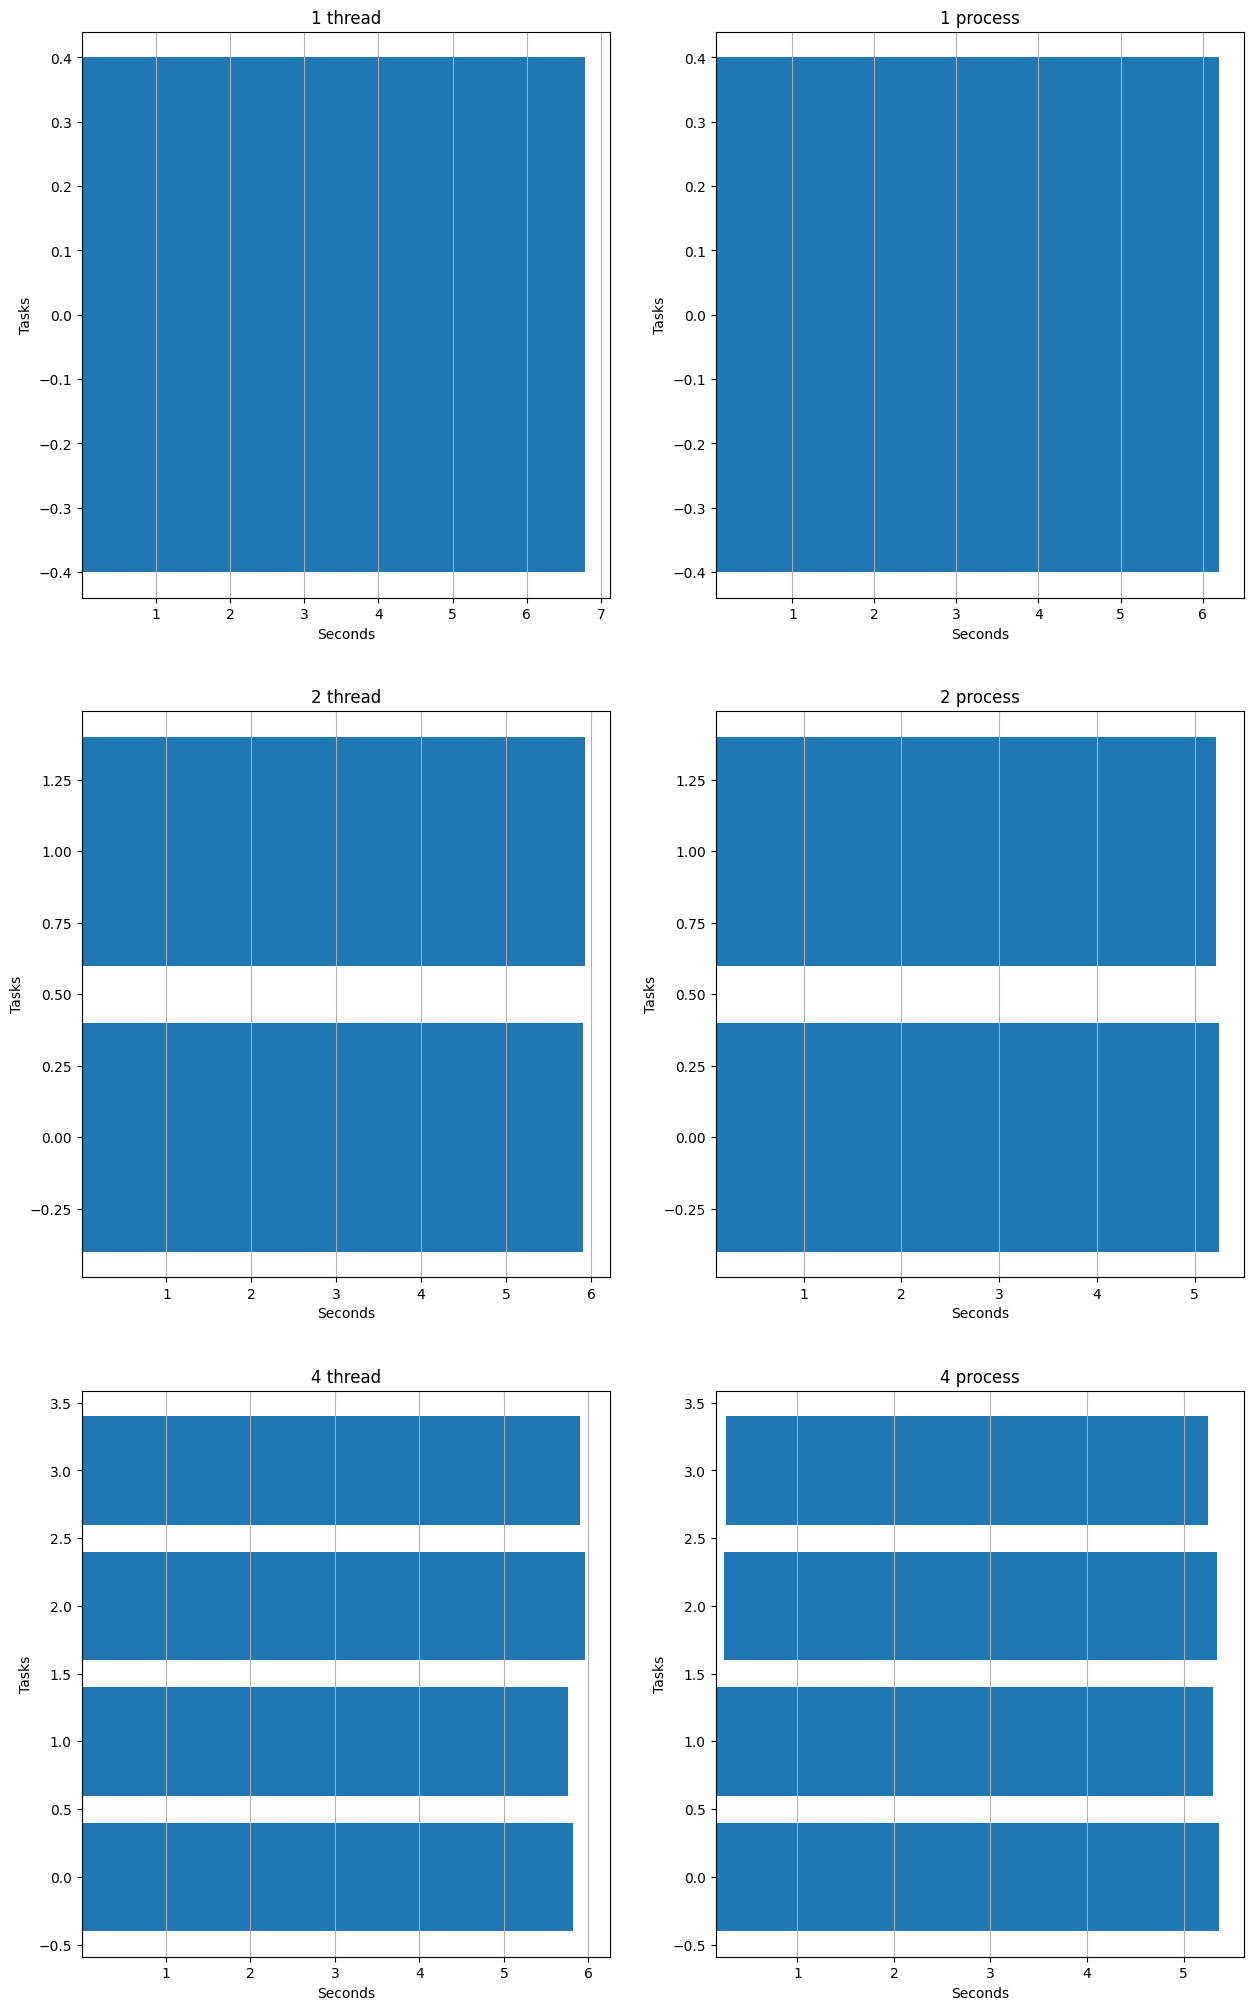

In [ ]:
# Запусти меня и предложи угадать результаты, занимает секунд 30 :)
visualize_fn(
    process_image,
    all_files,
    jobs=[1, 2, 4]
)

## Вывод

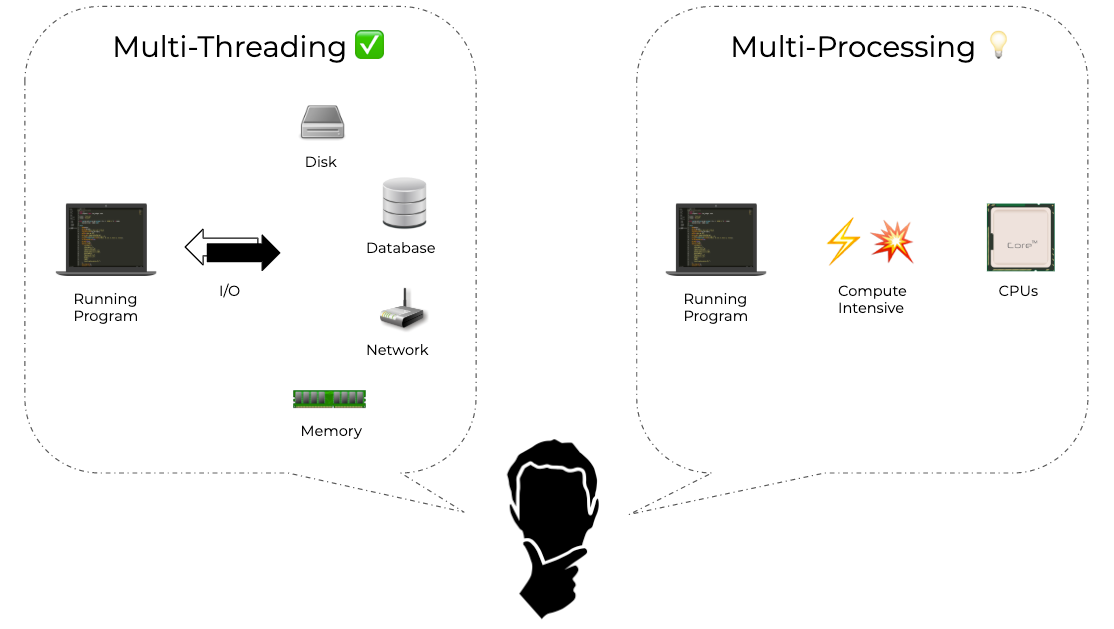